# Simple Forward Process for a single image

In [173]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np


### Main Forward Process Class
- handles single step generations step-by-sep until we reach a complete noise
- direct generation - Generate a complete noisy image from the any timestep t 

In [174]:
class ForwardProcess:
  """Forward diffusion process for adding noise to images in a diffusion model."""
  def __init__(self, image, timesteps, betas):
        """ Initialize the forward diffusion process.
        Args:
          image (torch.Tensor): Input image tensor to apply diffusion process to
          timesteps (int): Total number of diffusion timesteps
          betas (torch.Tensor): Noise schedule - variance values for each timestep
        """
        self.image = image 
        self.timesteps = timesteps
        self.betas = betas 

  def get_epislon(self):
    """Generate random noise tensor with same shape as input image.
        
        Returns:
            torch.Tensor: Random noise sampled from standard normal distribution
        """
    epislon = torch.randn_like(self.image)
    return epislon 
         

  def single_step(self, x_prev, t):
    """ Apply single forward diffusion step: x_t = √(1-β_t)x_{t-1} + √β_t ε
        
        This implements the Markovian forward process where each step depends only
        on the previous step and adds a controlled amount of Gaussian noise.
        
        Args:
            x_prev (torch.Tensor): Image from previous timestep
            t (int): Current timestep index
            
        Returns:
            torch.Tensor: Noisy image at timestep t
        """
    # Step 1: Get noise variance β_t for current timestep
    beta_t = self.betas[t]
    # Step 2: Scale previous image by √(1-β_t) - how much signal to preserve
    remaining_image =  torch.sqrt(1-beta_t) * x_prev     
    # Step 3: Add scaled noise √β_t ε - amount of noise to inject         
    noise_t =  torch.sqrt(beta_t) * self.get_epislon()   
    # Step 4: Combine preserved signal and added noise         
    xt =  remaining_image + noise_t
    return xt

  def all_steps(self):
    """ Apply forward diffusion process for all timesteps sequentially.

        Iteratively applies single_step() to generate the complete forward trajectory
        from clean image to pure noise over all timesteps.

        Returns:
            list[torch.Tensor]: List containing image at each timestep [x_0, x_1, ..., x_T]
    """
    x = [self.image]                     # Start with original clean image x_0
    for t in range(self.timesteps):
      xt = self.single_step(x_prev=x[t], t=t)
      x.append(xt)
    return x

  def direct_sampling(self, t):
     """ Directly sample x_t at any timestep using closed-form solution:
        x_t = √ᾱ_t x_0 + √(1-ᾱ_t) ε
        
        This avoids the need to iterate through all previous steps by using
        the cumulative product of alphas (ᾱ_t) for efficient sampling.
        
        Args:
            t (int): Target timestep to sample at
            
        Returns:
            torch.Tensor: Noisy image at timestep t
      """
     # Base case: return original image at t=0
     if t == 0:
       x = self.image
       return x
     # Step 1: Compute α_t = 1 - β_t (signal retention factor)
     alphas = 1 - self.betas 

     # Step 2: Compute ᾱ_t = ∏_{s=1}^t α_s (cumulative signal retention)
     alpha_cum_prod = torch.cumprod(alphas, dim=0)

     # Step 3: Scale original image by √ᾱ_t - remaining signal strength
     sqrt_alpha_cum_product_t = torch.sqrt(alpha_cum_prod[t-1]).view(-1, 1, 1)    
     remaining_image = sqrt_alpha_cum_product_t * self.image

     # Step 4: Add noise scaled by √(1-ᾱ_t) - cumulative noise level
     one_minus_alpha_cum = torch.sqrt(1-alpha_cum_prod[t-1]).view(-1, 1, 1)
     noise = one_minus_alpha_cum * self.get_epislon()

     # Step 5: Combine signal and noise components
     x_t = remaining_image + noise
     return x_t
  
  def get_schedule(self):
        """ Get the noise schedule parameters used in the diffusion process.
        
        Returns:
            dict: Dictionary containing beta and alpha schedules
                - "betas": noise variance schedule β_t
                - "alphas": signal retention schedule α_t = 1 - β_t
        """
        schedules = {
            "betas": self.betas,           # Noise variance at each step
            "alphas": 1 - self.betas       # Signal retention at each step
        }
        return schedules


### Function for ploting images and distribution graph

In [175]:
def plot_diffusion_process(x, t, schedules):
    """Visualize the forward diffusion process by plotting images at specified timesteps."""
    # Extract schedule parameters for potential use in titles
    alphas= schedules["alphas"]
    betas = schedules["betas"]

    plt.figure(figsize=(20, 4)) 
    # Plot each timestep as a separate subplot
    for i in range(len(t)):
        display_image = np.array(x[i])                      # Convert PyTorch tensor to numpy array 
        display_image = display_image.transpose(1, 2, 0)    # Transpose from PyTorch format (C, H, W) to matplotlib format (H, W, C)
        display_image = np.clip(display_image, 0, 1)        # Ensure pixel values are in valid range [0, 1] for display
        plt.subplot(1, len(t), i+1)
        plt.imshow(display_image)
        plt.axis('off') 

        if i == 0:
            plt.title(f'Original\nStep {t[i]}')
        else:
            # Display beta and alpha values for current timestep
            current_timestep = t[i]
            beta_val = betas[current_timestep - 1] if current_timestep > 0 else 0
            alpha_val = alphas[current_timestep - 1] if current_timestep > 0 else 1
            plt.title(f'Step {t[i]}\nβ={beta_val:.3f}, α={alpha_val:.3f}', 
                     fontsize=10)

    plt.tight_layout() 
    plt.show() 
    return

### Functions for ploting the probability distribution graph

In [176]:

def gaussian_pdf(x_axis_values, xt):
    """Calculate the Gaussian probability density function for given data.
    Computes the Gaussian/normal distribution PDF using the formula:
    f(x,μ,σ²) = (1/√(2πσ²)) * e^(-(x-μ)²/2σ²)

    Args:
        x_axis_values (np.ndarray): Array of x-values where PDF should be evaluated
        xt (np.ndarray): Flattened data array used to estimate distribution parameters
    
    Returns:
        tuple: A tuple containing:
            - gaussian (np.ndarray): Gaussian PDF values at x_axis_values
            - mean (float): Sample mean of the input data
            - std (float): Sample standard deviation of the input data

    """
    # Step 1: Calculate statistical parameters from the data
    mean = np.mean(xt); std = np.std(xt); variance = np.square(std)

    # Step 2: Calculate the Gaussian PDF components
    first_part = (1 / np.sqrt(2 * np.pi * variance))   # Normalization factor: 1/√(2πσ²)
    second_part_power = -np.square(x_axis_values-mean) / (2 * variance)   # Exponent: -(x-μ)²/2σ²
    second_part = np.exp(second_part_power)           # Exponential term: e^(-(x-μ)²/2σ²)
    gaussian =  first_part * second_part              # Step 3: Combine components to get final Gaussian PDF
    return gaussian, mean, std

def plot_pixel_distributions(xs, t):
    """Plot histograms of pixel value distributions with fitted Gaussian curves.
    
    This function visualizes how pixel value distributions change throughout the
    diffusion process. For each timestep, it creates a histogram of all pixel values
    and overlays the corresponding Gaussian PDF to show how the distribution
    approaches a normal distribution as noise is added.
    
    Args:
        xs (list[torch.Tensor]): List of image tensors at different timesteps
                                Each tensor should have shape (C, H, W)
        t (list[int]): List of timestep indices corresponding to xs
    """
    plt.figure(figsize=(20, 4)) 
    for i in range(len(t)):
        xt = np.array(xs[i])
        xt = xt.flatten()     # Flatten all pixel values into 1D array for histogram

        #  Define x-axis range for Gaussian curve plotting
        x_axis_values = np.linspace(np.min(xt), np.max(xt), xt.shape[0])

        # Calculate theoretical Gaussian distribution fitted to data
        gaussian, mean, std = gaussian_pdf(x_axis_values=x_axis_values, xt=xt)

        # Step 4: Plot histogram of data and Gaussian PDF
        plt.subplot(1, len(t), i+1)
        plt.hist(xt, bins=30, density=True, alpha=0.5, color='skyblue', label='Empirical Distribution')
        plt.plot(x_axis_values, gaussian, 'r-', linewidth=2, label='Fitted Gaussian')
        plt.title(f'Step {t[i]}\nμ={mean:.2f}, σ={std:.2f}', fontsize=11)
        plt.xlabel('Pixel Value')
        plt.ylabel('Probability Density')
        plt.grid(True, alpha=0.3)
        
        # Add legend for first subplot to avoid clutter
        if i == 0:
            plt.legend(fontsize=9)
    
    plt.show()
    

### Get Image

In [177]:
img_path = "cat.jpg"
image = Image.open(img_path)
img_to_tensor = transforms.ToTensor()
image = img_to_tensor(image)                   # This is our x0
print(image.shape)


torch.Size([3, 401, 600])


### Runs single step process over timestep t
- defines timesteps
- initializes the variance schedule

/tmp/ipykernel_5347/1224548123.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  display_image = np.array(x[i])                      # Convert PyTorch tensor to numpy array


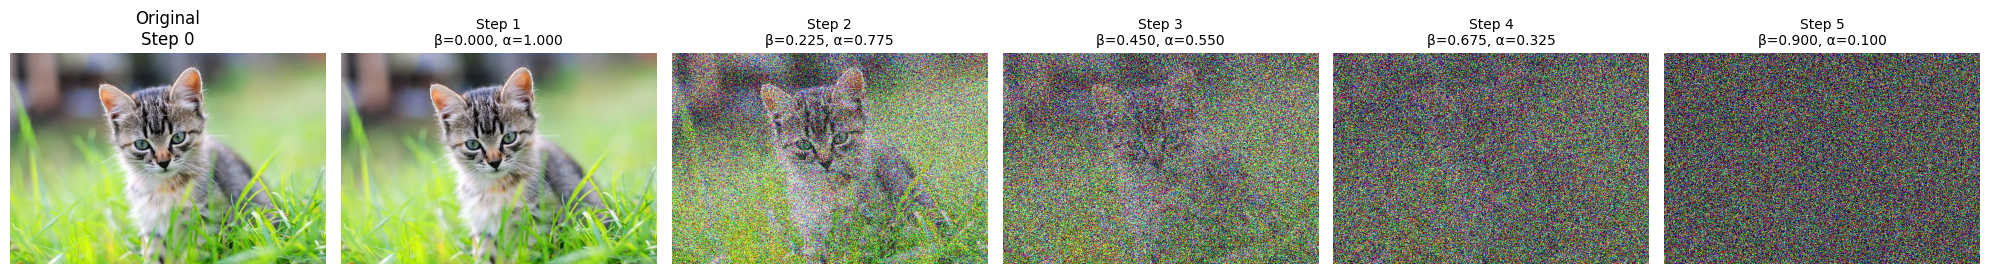

/tmp/ipykernel_5347/1826403719.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xt = np.array(xs[i])


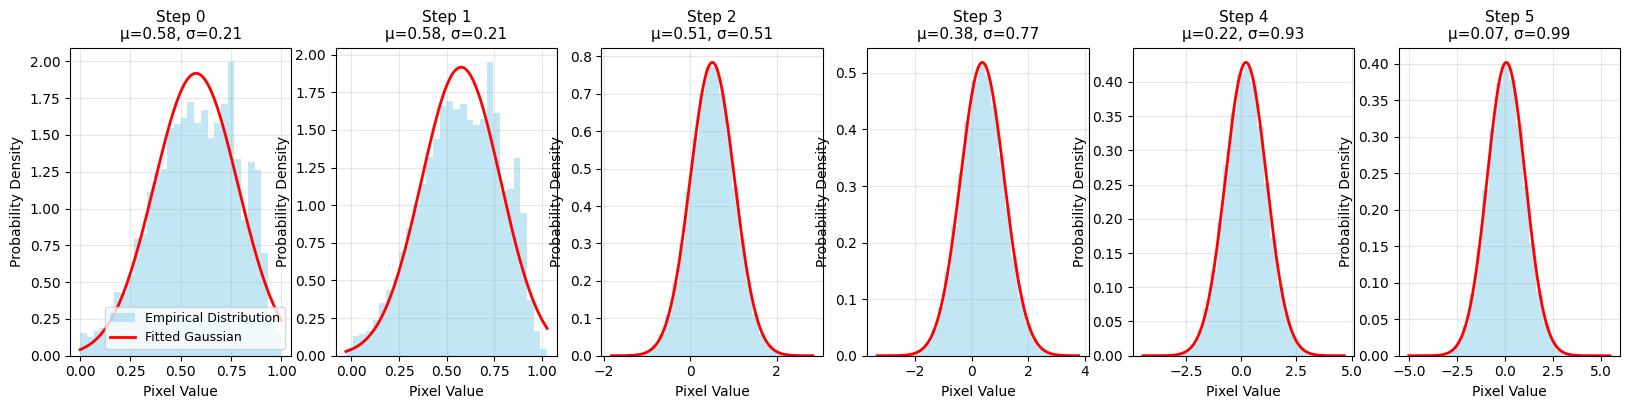

In [178]:
timesteps = 5 
# betas = torch.linspace(start=0.0001, end=0.02, steps=timesteps)            # change the values of beta to see different changes
betas = torch.linspace(start=0.0001, end=0.9, steps=timesteps)
fp = ForwardProcess(timesteps=timesteps, image=image, betas=betas)
x = fp.all_steps()
schedules = fp.get_schedule()

t = list(range(timesteps+1)) if timesteps <= 5 else [0, 1, 5, timesteps]
plot_diffusion_process(x=x, t=t, schedules=schedules)
plot_pixel_distributions(xs=x, t=t)


### Runs the direct sampling process
- defines timesteps
- initializes the variance schedule

/tmp/ipykernel_5347/1224548123.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  display_image = np.array(x[i])                      # Convert PyTorch tensor to numpy array


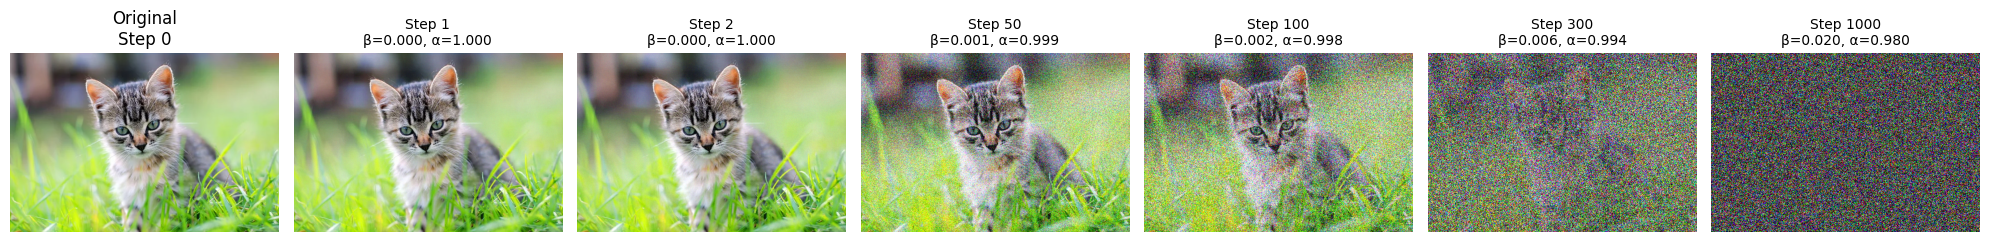

/tmp/ipykernel_5347/1826403719.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xt = np.array(xs[i])


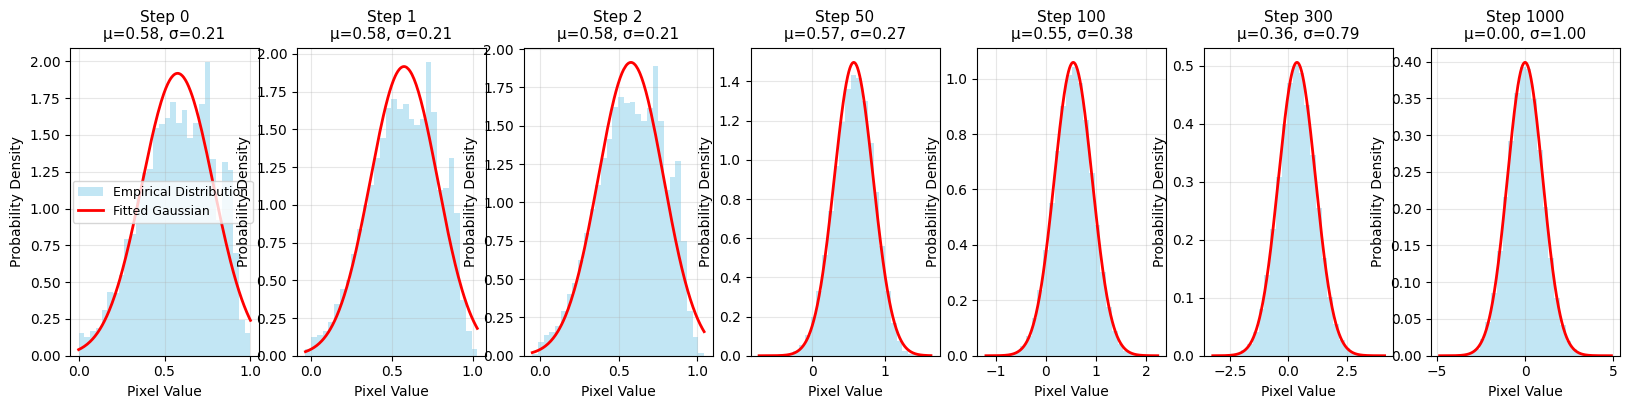

In [179]:
timesteps = 1000
betas = torch.linspace(start=0.0001, end=0.02, steps=timesteps)
fp = ForwardProcess(timesteps=timesteps, image=image, betas=betas)
x=[]
intervals = [0, 1, 2, 50, 100, 300, 1000]
for t in intervals:
    xt = fp.direct_sampling(t=t)
    x.append(xt)
schedules = fp.get_schedule() 
plot_diffusion_process(x=x, t=intervals, schedules=schedules)
plot_pixel_distributions(xs=x, t=intervals)

### Plot variance schedule over timestep t

/tmp/ipykernel_5347/3778968860.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  betas = np.array(betas)


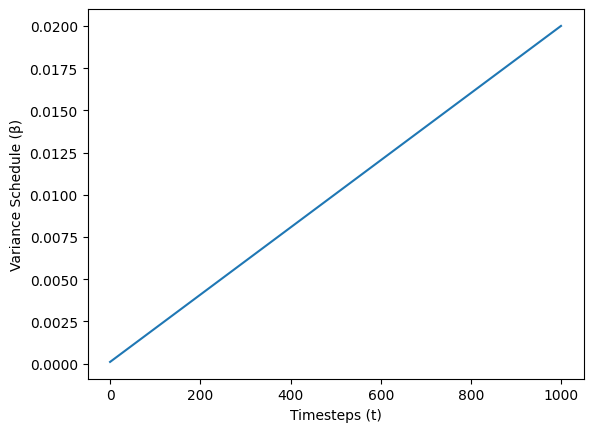

In [180]:
# plot betas
betas = schedules["betas"]
betas = np.array(betas)

plt.plot(betas, label="betas")
plt.xlabel('Timesteps (t)')
plt.ylabel('Variance Schedule (β)')
# plt.grid()
plt.show()


/tmp/ipykernel_5347/1673882472.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  alphas = np.array(alphas)


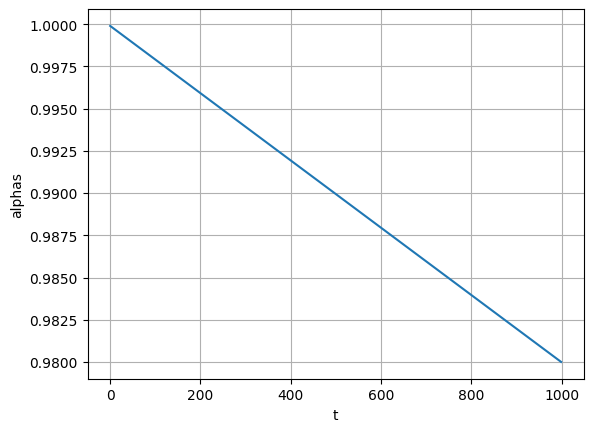

In [181]:
alphas = schedules["alphas"]
alphas = np.array(alphas)
plt.plot(alphas, label="alphas")

plt.xlabel('t')
plt.ylabel('alphas')
plt.grid()
plt.show()